# Static maps¶
# Data¶

https://autogis-site.readthedocs.io/en/latest/notebooks/L5/01_static_maps.html

You should have following Shapefiles in the data folder:

- addresses.shp

- metro.shp

- roads.shp

- some.geojson

- TravelTimes_to_5975375_RailwayStation.shp

In case you don’t see the required files in the data folder, you can download them from this link.

You can download and extract the data into a folder data using these commands:

   cd autogis/notebooks/L5
   
   wget https://github.com/Automating-GIS-processes/Lesson-5-Making-Maps/raw/master/data/dataE5.zip
   
   unzip dataE5.zip -d data

# Static maps in geopandas


- when using the plot() method in geopandas, we are actually using the tools available from matplotlib pyplot.

Let’s refresh our memory about the basics of plotting maps by creating a static accessibility map with roads and metro line on it (three layers on top of each other in the same figure). Before plotting the layers, we need to check that they are in the same coordinate reference system.

As usual, we start by importing the useful modules and reading in the input files:

In [1]:
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

#filepaths
grid_fp = "TravelTimes_to_5975375_RailwayStation.shp"
roads_fp = "roads.shp"
metro_fp = "metro.shp"

#read files
grid = gpd.read_file(grid_fp)
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)

- Check the coordinate reference system of the input files

In [2]:
print(roads.crs)
print(grid.crs)
print(metro.crs)

epsg:2392
epsg:3067
epsg:2392


- Roads and the metro are in an old Finnish crs (EPSG:2392), while the grid is in ETRS89 / TM35FIN (EPSG:3067):

In [3]:
# Check CRS names
print(f"Roads crs: {CRS(roads.crs).name}")
print(f"Metro crs: {CRS(metro.crs).name}")
print(f"Grid crs: {CRS(grid.crs).name}")

Roads crs: KKJ / Finland zone 2
Metro crs: KKJ / Finland zone 2
Grid crs: ETRS89 / TM35FIN(E,N)


- Reproject the geometries to ETRS89 / TM35FIN based on the grid crs:

In [4]:
#reproject crs of roads and metro to the grid crs
roads = roads.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)

Now the layers should be in the same crs

In [5]:
roads.crs == metro.crs == grid.crs

True

Once the data are in the same projection, we can plot them on a map.

- Make a visualization using the plot() -function in Geopandas

- plot first the grid using “quantiles” classification scheme

- then add roads and metro in the same plot

Plotting options for the polygon:

- Define the classification scheme using the scheme parameter

- Change the colormap using the cmap parameter. See colormap options from matplotlib documentation.

- You can add a little bit of transparency for the grid using the alpha parameter (ranges from 0 to 1 where 0 is fully transparent)

Plotting options fo the lines:

- adjust color using color parameter. See color options from matplotlib pyplot documentation.

- change linewidth if needed

For better control of the figure and axes, use the plt.subplots function before plotting the layers.

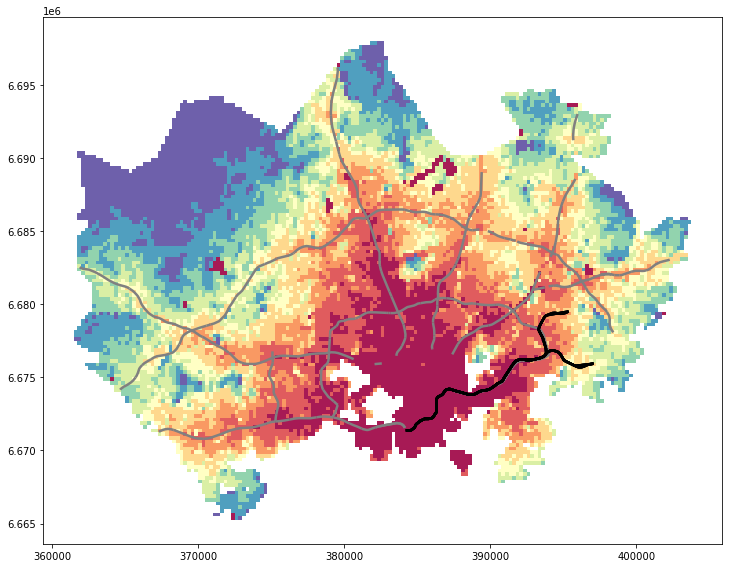

In [6]:
#Create one subplot. Control figure size with matplotlib object
fig, ax = plt.subplots(figsize=(12,8))

#visualize the travel times into 9 clases using "Quantiles" classification scheme
grid.plot(ax=ax, column='car_r_t', linewidth= 0.03, cmap="Spectral", scheme='quantiles', k=9, alpha=0.9)

#add roads on top of the grid
#use ax parameter to define the map, in which secondary items are plotted on top
roads.plot(ax=ax, color='grey', linewidth=2.5)

#add metro on top of the previous map
metro.plot(ax=ax, color="black", linewidth=2.5)

#remove the empty white space around the axes
plt.tight_layout()

#save the figure as png file with resolution of 300 dpi
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)
            

# Adding a Legend
- enable legend for a geopandas plot by setting legend=True in the plotting parameters
- plotting the figure without a classification scheme you get a color bar as the legend item
- and it is easy to add a label for the legend using legend_kwds.

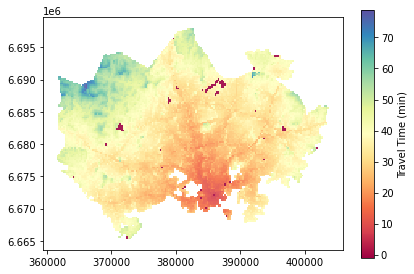

In [7]:
#create one subplot, control figure size here
fig , ax = plt.subplots(figsize=(6,4))

#visualize the travel time without a classification scheme
grid.plot(ax = ax, column= 'car_r_t',
            linewidth=0.03,
            cmap= "Spectral",
            alpha= 0.9,
            legend=True,
            legend_kwds = {"label": "Travel Time (min)" }
         )

#remove the empty white space around the axes
plt.tight_layout()

For plotting a map using a classification scheme, a different legend shows the class values.
- control position and title of legend using matplotlib tools

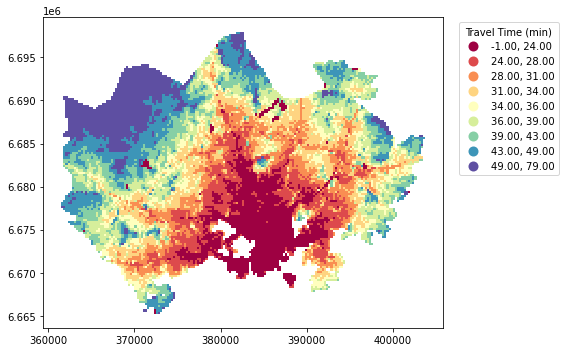

In [8]:
#create one subplot. Control figure size here
fig, ax = plt.subplots(figsize=(10,5))

#visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot( ax= ax, 
            column="car_r_t",
              linewidth=0.03,
                  cmap="Spectral",
                      scheme = "quantiles",
                          k=9,
                              legend=True)

ax.get_legend().set_bbox_to_anchor((1.3,1))
ax.get_legend().set_title("Travel Time (min)")

#Remove the empty white space around the axes.
plt.tight_layout()

# Adding basemap from external source¶
It is often useful to add a basemap to your visualization that shows e.g. streets, placenames and other contextual information. 

This can be done easily by using ready-made background map tiles from different providers such as OpenStreetMap or Stamen Design. 

- A Python library called contextily is a handy package that can be used to fetch geospatial raster files and add them to your maps. 
- Map tiles are typically distributed in Web Mercator projection (EPSG:3857), hence it is often necessary to reproject all the spatial data into Web Mercator before visualizing the data.

In this tutorial, we will see how to add a basemap underneath our previous visualization.


- Read in travel time data

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
%matplotlib inline

grid_fp = "TravelTimes_to_5975375_RailwayStation.shp"

#Read data
grid = gpd.read_file(grid_fp)
grid.head(3)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,30133,50,31872,56,5785642,32940,121,146,32940,113,133,5975375,29626,423,"POLYGON ((382500.000 6697750.000, 382250.000 6..."


Check the inpit crs

In [10]:
print(grid.crs)

epsg:3067


Reproject the layer to ESPG 3857 projection (Web mercator)

In [11]:
#reproject to epsg 3857
data = grid.to_crs(epsg=3857)
print(data.crs)

epsg:3857


Now the crs is epsg:3857. The coordinate values in the geometry column have changed

In [12]:
data.head(2)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((2767221.646 8489079.101, 2766716.966..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((2767726.329 8489095.521, 2767221.646..."


- next plot data using geopandas and add a basemap for the plot (use add_basemap() from contextily library

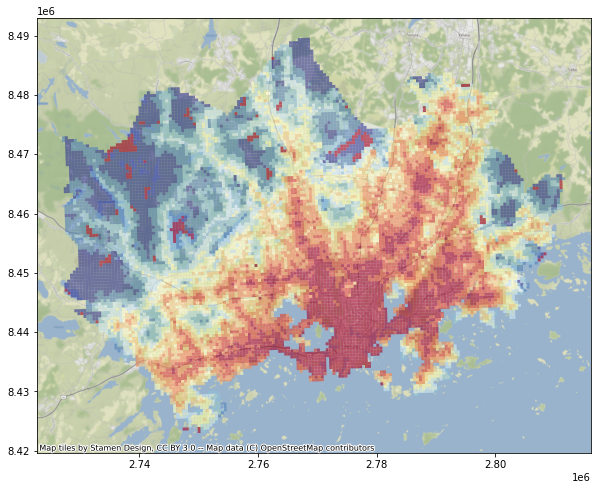

In [13]:
#control figure size here
fig, ax = plt.subplots(figsize=(12,8))

#plot the data
data.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme='quantiles', k=9, alpha=0.6)

#add a basemap
ctx.add_basemap(ax)

the map has a background map that is by default using the Stamen Terrain background from Stamen Design.

- Contextily’s tile_providers contain a list of providers and styles that can be used to control the appearence of your background map:

In [14]:
dir(ctx.providers)

['AzureMaps',
 'BasemapAT',
 'CartoDB',
 'CyclOSM',
 'Esri',
 'FreeMapSK',
 'Gaode',
 'GeoportailFrance',
 'HERE',
 'HEREv3',
 'HikeBike',
 'Hydda',
 'Jawg',
 'JusticeMap',
 'MapBox',
 'MapTiler',
 'MtbMap',
 'NASAGIBS',
 'NLS',
 'OPNVKarte',
 'OneMapSG',
 'OpenAIP',
 'OpenFireMap',
 'OpenRailwayMap',
 'OpenSeaMap',
 'OpenSnowMap',
 'OpenStreetMap',
 'OpenTopoMap',
 'OpenWeatherMap',
 'SafeCast',
 'Stadia',
 'Stamen',
 'Strava',
 'SwissFederalGeoportal',
 'Thunderforest',
 'TomTom',
 'USGS',
 'WaymarkedTrails',
 'nlmaps']

For each map provider, there are multiple style options

In [15]:
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH', 'BlackAndWhite'])

It is possible to change the tile provider using the *source* parameter in *add_basemap()* function. 

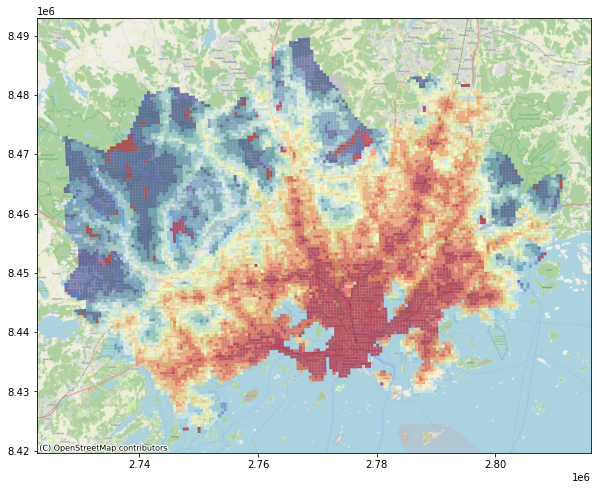

In [16]:
#control the figure size here
fig, ax = plt.subplots(figsize= (12,8))

#plot the data
data.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

#add basemap with basic OpenStreetMap visualization
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

Take a subset of data to see the background map characteristics in better detail

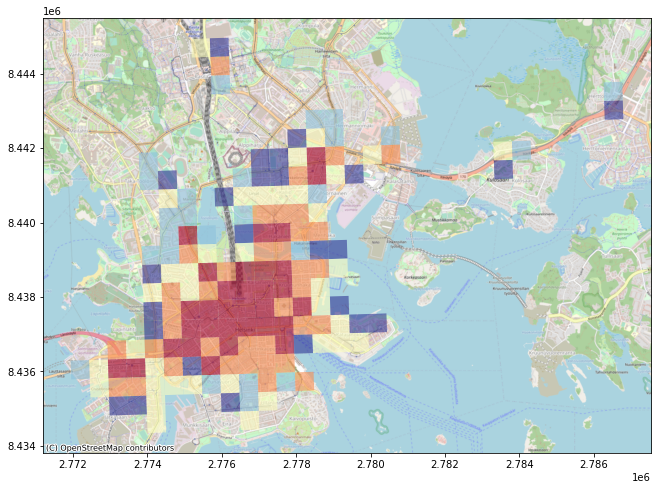

In [17]:
#Control the figure size in here
fig, ax = plt.subplots(figsize=(12,8))

#subset the data to seel only grid squares near the destination: column mask public transit travel time < than 15 mins excluding nulls
subset = data.loc[ (data['pt_r_t']>=0) & (data['pt_r_t'] <= 15) ]

#plot the data from subset
subset.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme='quantiles', k=5, alpha=0.6)

#add basemap with OSM_A style
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

- Now the map has much more details in it as the zoom level of the background map is larger. 
- By default contextily sets the zoom level automatically but it is possible to also control that manually using parameter zoom. 
- The zoom level is by default specified as auto but you can control that by passing in zoom level as numbers ranging typically from 1 to 19 (the larger the number, the more details your basemap will have).

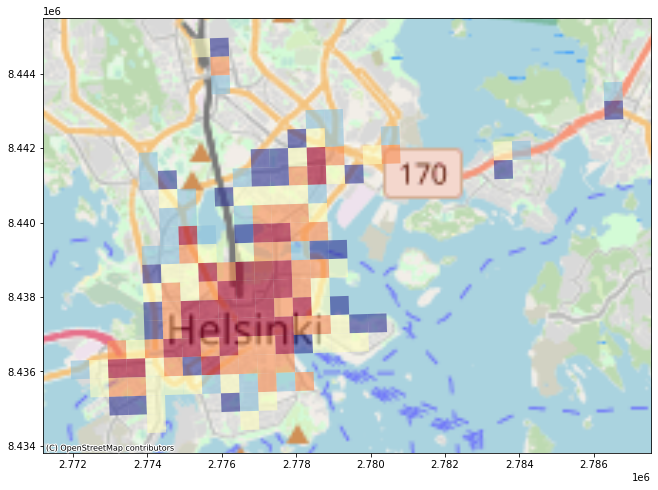

In [18]:
#control the figure size here
fig, ax = plt.subplots(figsize=(12,8))

#plot the data from the subset
subset.plot(ax=ax, column= 'pt_r_t', cmap= 'RdYlBu', linewidth=0, scheme='quantiles', k=5, alpha=0.6)

#add base map with OSM_A style using zoom level of 11
ctx.add_basemap(ax, zoom=11, source= ctx.providers.OpenStreetMap.Mapnik)

Now the map has less detail ( blurry for a small area)

- use ax.set_xlim() and ax.set_ylim to crop map without altering the data. 
- The parameters takes input coordinates min and max for both axis x and y.
- Change 'Credits' text by using attribution

Add details about the data source, plot the original data, crop the map.

In [19]:
credits = 'Travel time data by Digital Geography Lab, Map Data OpenStreetMap Contributors'

(8430000.0, 8470000.0)

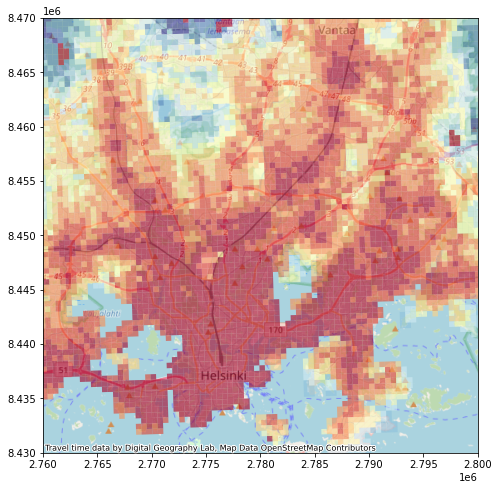

In [20]:
#control figure size here
fig, ax = plt.subplots(figsize=(12,8))

#plot the data
data.plot(ax=ax, column= 'pt_r_t', cmap='RdYlBu', linewidth=0, scheme='quantiles',k=9, alpha=0.6)

#add a basemap with OSM_A style using zoom level of 11
#modify the attribution
ctx.add_basemap(ax, zoom= 11, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik)

#crop the figure
ax.set_xlim(2760000,2800000)
ax.set_ylim(8430000, 8470000)

It is also possible to use many other map tiles from different Tile Map Services as the background map. 

A good list of different available sources can be found from here. 

When using map tiles from different sources, it is necessary to parse a url address to the tile provider following a format defined by the provider.

- Next, we will see how to use map tiles provided by CartoDB. To do that we need to parse the url address following their definition

'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{scale}.png' 
where:

    {s}: one of the available subdomains, either [a,b,c,d]

    {z} : Zoom level. We support from 0 to 20 zoom levels in OSM tiling system.

    {x},{y}: Tile coordinates in OSM tiling system

    {scale}: OPTIONAL “@2x” for double resolution tiles

    {style}: Map style, possible value is one of:

        light_all,

        dark_all,

        light_nolabels,

        light_only_labels,

        dark_nolabels,

        dark_only_labels,

        rastertiles/voyager,

        rastertiles/voyager_nolabels,

        rastertiles/voyager_only_labels,

        rastertiles/voyager_labels_under

definition for CARTODB map - https://github.com/CartoDB/basemap-styles#1-web-raster-basemaps


We will use this information to parse the parameters in a way that contextily wants them:

(8435000.0, 8442500.0)

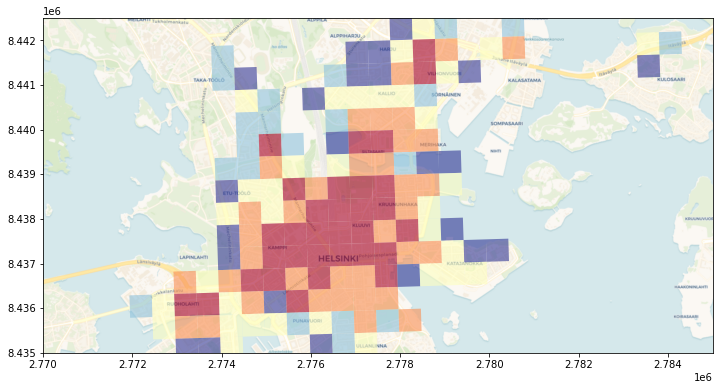

In [21]:
#control figure size in here
fig, ax = plt.subplots( figsize=(12,8) )

#the formatting should follow: 'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{scale}.png'
#specify the style to use
style = 'rastertiles/voyager'
cartodb_url = 'https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png' % style

#plot the data from a subset
subset.plot(ax=ax, column='pt_r_t',cmap='RdYlBu', linewidth=0, scheme='quantiles', k=5, alpha=0.6)

#add a basemap with'OSM_A' style using a zoom level of 14
ctx.add_basemap(ax, zoom=14, attribution="", source=cartodb_url)

#crop the figure
ax.set_xlim(2770000,2785000)
ax.set_ylim(8435000,8442500)

- A different background map coming from CartoDB

change the style of the map from rastertiles/voyager to 'dark_all'

(8435000.0, 8442500.0)

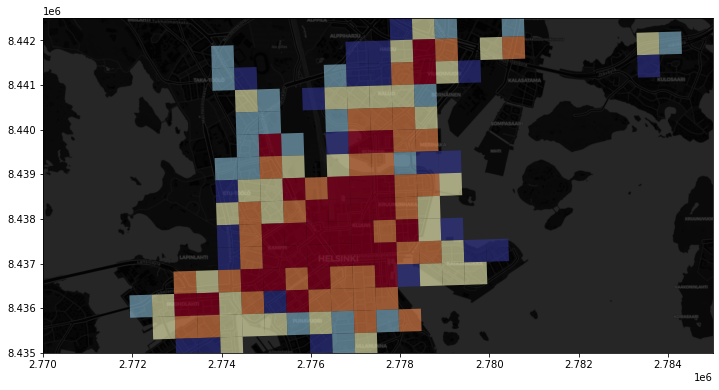

In [23]:
#control the figure size here
fig, ax = plt.subplots(figsize=(12,8))

#the formatting should follow: 'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{r}.png'
style = "dark_all"
cartodb_url = 'https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png' % style

#plot the data from subset
subset.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=5, alpha=0.6)

#add a basemap with OSM_A style using zoom level of 14
ctx.add_basemap( ax, zoom=14, attribution="", source = cartodb_url)

#crop the figure
ax.set_xlim(2770000,2785000)
ax.set_ylim(8435000,8442500)

Now we have dark background map fetched from CartoDB. In a similar manner, you can use any map tiles from various other tile providers such as the ones listed in leaflet-providers.